In [1]:
# import os 
from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import lightning.pytorch as pl
import torch
import hydra
import numpy as np  
from hydra import compose, initialize
from omegaconf import OmegaConf,DictConfig
import datetime
import matplotlib.pyplot as plt
import xarray as xr
from celluloid import Camera
import datetime
import subprocess
import sys
import os
from hydra import compose, initialize
from omegaconf import OmegaConf
from visualization import rollout
import pickle

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config",overrides=["experiment=one_month_multiple_variable_v100"])
scratch = os.environ['SCRATCH']
work = os.environ['WORK']

In [2]:
delta = True
normalization = 'climatology'
run_id = '9cbb1f05'
test = IPSL_DCPP('test',
                 lead_time_months=1,
                 surface_variables=cfg.experiment.surface_variables,
                 depth_variables=cfg.experiment.depth_variables,
                 generate_statistics=False,
                 delta=delta,
                 normalization=normalization
                )
dataloader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False,num_workers=1)
out = subprocess.run(f'ls -tr {scratch}/checkpoint_{run_id}/ | tail -n 1',shell=True,capture_output=True,text=True)
path = out.stdout.strip("\n")
checkpoint_path = torch.load(f'{scratch}/checkpoint_{run_id}/{path}',map_location=torch.device('cpu'))
model = hydra.utils.instantiate(
    cfg.experiment.module,
    backbone=hydra.utils.instantiate(cfg.experiment.backbone),
    dataset=test
)
model.load_state_dict(checkpoint_path['state_dict'])
rollout_data_zeroes = rollout(12,dataloader,model,True)
rollout_data = rollout(12,dataloader,model,False)

/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


['1983-01']
['1983-02']
['1983-03']
['1983-04']
['1983-05']
['1983-06']
['1983-07']
['1983-08']
['1983-09']
['1983-10']
['1983-11']
['1983-12']
['1983-01']
['1983-02']
['1983-03']
['1983-04']
['1983-05']
['1983-06']
['1983-07']
['1983-08']
['1983-09']
['1983-10']
['1983-11']
['1983-12']


In [18]:
un_preds = []
un_batchs = []
un_preds_zeroes = []
for i in range(12):
    unnormalized_pred,unnormalized_batch = test.denormalize(rollout_data[0][i],rollout_data[1][i])
    unnormalized_pred_zero,unnormalized_batch_zero = test.denormalize(rollout_data_zeroes[0][i],rollout_data_zeroes[1][i])

    un_preds.append(unnormalized_pred)
    un_preds_zeroes.append(unnormalized_pred_zero)
    un_batchs.append(unnormalized_batch)
    

In [19]:
pred = [x['next_state_surface'].squeeze() for x in un_preds]
pred_zeroes = [x['next_state_surface'].squeeze() for x in un_preds_zeroes]
batches = [x['next_state_surface'].squeeze() for x in un_batchs]

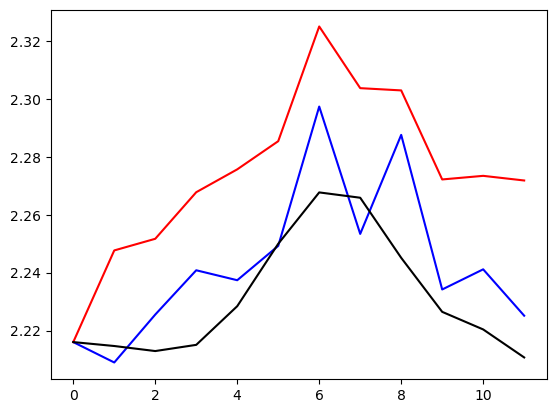

In [21]:
variable_name = 'cVeg'
#long_name = 'Daily Maximum Near-Surface Air Temperature'
long_name = 'Carbon Mass in Vegetation'
var_index=test.surface_variables.index(variable_name)
plt.plot(np.nanmean(np.stack(pred)[:,var_index],axis=(-1,-2)),color='blue')
plt.plot(np.nanmean(np.stack(pred_zeroes)[:,var_index],axis=(-1,-2)),color='red')
plt.plot(np.nanmean(np.stack(batches)[:,var_index],axis=(-1,-2)),color='black')